# Milestone 4 - Independent Project

## Author - Eowyn Baughman



## Instructions

1. Generate a clear statement problem and provide location for dataset
2. Provide a clear solution to the problem for a non-technical audience
3. Visually explore the data to generate insight and include summary statistics
4. Use an appropriate statistical analysis method
5. Prepare the data via cleaning, normalization, encoding, et cetera
6. Generate and evaluate a working model (hypothesis, linear, or time series)
7. Draw direct inferences and conclusions from model results
8. Use professional coding standards and techniques including:

    - explanatory markdown text
    - proper code comments
    - functions to minimize redundant code
    - minimize hard-coded variables

### Note
Please use the <a class="icon-pdf" title="Independent Project Rubric" href="https://library.startlearninglabs.uw.edu/DATASCI410/Handouts/DATASCI%20410%20Independent%20Project%20Rubric.pdf" target="_blank" rel="noopener">Rubric</a> as a general guide for your project.

# Abstract
## Problem
My research question is: How does crime density relate to housing prices in Seattle? What about different kinds of crime? Can we detect and quantify a price suppression due to high rates total crime? Are there substantially different *kinds of houses* in different crime-regime areas?

A former roommate was thrilled to get a big, newer house for a steep discount and he said it was because of "all the shootings, but I'm a big guy, I'm not bothered!" I am super curious about whether we can detect this kind of phenomenon statistically, and how much of a difference it might make especially in a market where bidding wars and cash-offers are the norm, and neighborhoods where 1-2 blocks can make a difference. 

I pulled police incident reports from 2013 from seattle.data.gov. Merging that data with the 2014-2015 housing data on lat/lon was a pretty challenging problem. I ultimately used Tableau Public to join the data and apply a common lat/lon hex-binning to generate a merged dataset where each house has the crime count within ~1/4 mile radius. Now I'm pulling that into python (as .csv) to do the bulk of the milestone. 

Notes about the inner join on the crime and housing datasets:

* Housing data is missing downtown
* Crime data is missing outside city limits
* Within city limits, almost everywhere had at least one crime in 2013
* Inner join ensures only data with both house and crime information is included
* This means we are excluding houses with zero crime of any sort in 2013, a worthwhile tradeoff to avoid including data for which crimes occurred but were not available (ie outside city limits)
* Given the breadth of the crime dataset - including even minor traffic and parking violations -- it is fair to assume that the vast majority of 0 crime hexbins are due to one or the other dataset being absent, than a true lack of law-breaking

Violent crimes: ['ROBBERY', 'ASSAULT', 'THREATS', 'WEAPON', 'HOMICIDE','BIAS INCIDENT']

Property crimes: ['SHOPLIFTING','CAR PROWL','OTHER PROPERTY','BURGLARY','BURGLARY-SECURE PARKING-RES',
 'VEHICLE THEFT','STOLEN PROPERTY','PICKPOCKET','BIKE THEFT','MAIL THEFT','LOST PROPERTY'
 'PURSE SNATCH','COUNTERFEIT']

Nuisance crimes: ['DISTURBANCE','PROPERTY DAMAGE','TRESPASS','NARCOTICS','DISPUTE','RECKLESS BURNING'
 'PORNOGRAPHY','ANIMAL COMPLAINT','LIQUOR VIOLATION''BIAS INCIDENT','PROSTITUTION'
 'ILLEGAL DUMPING','DISORDERLY CONDUCT','LOITERING','PUBLIC NUISANCE','FIREWORK']

Other crimes: ['OBSTRUCT','DUI','THEFT OF SERVICES','WARRANT ARREST','FRAUD','EMBEZZLE','TRAFFIC'
 'FORGERY','RECOVERED PROPERTY','FALSE REPORT','VIOLATION OF COURT ORDER',
 'STAY OUT OF AREA OF DRUGS','EXTORTION','[INC - CASE DC USE ONLY]',
 'ELUDING','ESCAPE','METRO' 'HARBOR CALLS','HARBOR CALLs','INJURY']



## Conclusion

This was a difficult problem. There is a large (over \$100K), statistically significant difference between house prices in low and high crime areas. A great deal of the difference is due to the houses themselves, which tend to be larger, have more bedrooms, and sit on bigger lots (ie bigger yards) in low-crime areas. This was demonstrated with violin plots showing distributions in low and high crime areas of various features, and also by performing classical and boostrap significance tests on the difference of means for both low- and high-crime areas. 

Nonetheless, there are clear signs of total crime having a significant impact on price even given the other considerations. This was presented in a few different ways:
* Modeling the same house but varying its crime density
* Visualizing features vs price, shaded by crime, and seeing that for the same condition and # bedrooms, among other features, the houses were still more expensive in low-crime areas
* Visualizing distributions of features in low- vs high-crime areas and observing price peaks that don't seem attributable to other features
* Calcuating adjusted R^2 on linear models both including and excluding total crime, and seeing that the amount of variance in price captured by the model is improve about 8\% when crime is included
* Performing forward selection and seeing that crime is both selected and has a statistically non-zero coefficient

Four different kinds of linear models were trained on 70\% of the data (split into low and high crime) and tested on 20\% of the data. Hyper-parameters were tuned for the Lasso/Ridge model, and partial slopes examined. One model was selected for high crime areas and two more for low crime areas. The low crime model selection was tie-broken by calculating the 95\%/5\% confidence intervals (calculated via bootstrapping) on all the model coefficients (parameters in OLS parlance) and comparing their spreads, the logic being that a lower-variability on the coefficient indicates a more stable model, all else equal. Finally, the high and low crime models were used to predict 10\% of the data (validation) which had been set aside from early on.

The selected models had their intercepts and coefficients interpretted in real-world terms of what kinds of features make a home desirable to prospective home buyers. Walk into any open house in a town house in Wallingford on a Sunday if you don't believe me. Some places have 4 pre-inspections going on *during* the open house.  

The model performance on the test and validation data was mediocre, in my view, with Mean Absolute Error (MAE) around \$100K. I think this is because only the square footage and lot size variables appeared linearly correlated in the aggregate; other features tended towards clusters. Also, the lack of downtown housing data meant that one of the higher crime areas in the city wasn't included at all. To improve this analysis, I would like to use longitudinal house and crime data; use house prices that include downtown and/or crime data that includes King County outside city limits; perform cluster analysis and develop models for individual clusters; include sister-cities with less rabid housing markets or years in Seattle with slower housing markets. I bought my house in 2014 and was so desperate at various points that I'd have overlooked many things that I normally wouldn't, and that's a hard thing to filter out of the data when you only have 1-2 years to work with. 

In [265]:
# Location of dataset. Please update this to your local hard drive.
file = """C:\\Users\\eowyn\\Data_Science\\DS410\\Milestone04\\kc_house_and_crime_hexbin_data.csv"""

In [235]:
# Load necessary libraries
import pandas as pd
import numpy as np
import numpy.random as nr
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.stats.weightstats as ws
import numpy as np
from scipy.stats import kstest
from sklearn.preprocessing import scale
import sklearn.preprocessing as sp
from scipy import stats
import statsmodels.stats.weightstats as ws
from statistics import mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.feature_selection import *
from sklearn.decomposition import PCA
from scipy.stats import *
import scipy.stats as ss
from operator import add
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.linear_model import BayesianRidge
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict

In [236]:
# Load data and check it out

df = pd.read_csv(file, thousands = ',')  # comma to let price be numeric
print(df.info())
print(df.head(n=3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7086 entries, 0 to 7085
Data columns (total 26 columns):
Index             7086 non-null int64
Id                7086 non-null int64
Date              7086 non-null object
Hexlat            7086 non-null float64
Hexlong           7086 non-null float64
Price             7086 non-null int64
Bathrooms         7086 non-null float64
Bedrooms          7086 non-null int64
Condition         7086 non-null int64
Floors            7086 non-null float64
Grade             7086 non-null int64
Sqft Above        7086 non-null int64
Sqft Basement     7086 non-null int64
Sqft Living       7086 non-null int64
Sqft Living15     7086 non-null int64
Sqft Lot          7086 non-null int64
Sqft Lot15        7086 non-null int64
View              7086 non-null int64
Waterfront        7086 non-null int64
Yr Built          7086 non-null int64
Yr Renovated      7086 non-null int64
Zipcode           7086 non-null int64
Nuisance Crime    6347 non-null float64
Other Cr

In [237]:
# Functions for data cleaning

#  Given a pandas series, return series with outliers replaced by nan
#  For series with few unique variables, do nothing and return the series
def replace_outliers_with_na(x):
    if len(x.unique()) < 5:
        return x
    xbar = np.mean(x) # Mean, ignoring NA
    xsd = np.std(x) # Standard deivation, ignoring NA
    LL = xbar - 4*xsd # Lower limit for outlier detection
    UL = xbar + 4*xsd # Upper limit for outlier detection
    return x.map(lambda y: y if y > LL and y < UL else np.nan) # Change outliers to NA

# Given a pandas series x, replace any NA with median of non-NA values
def replace_na_with_median(x):
    return x.fillna(np.nanmedian(x))

In [238]:
# Data Cleaning

# OLS has problems with column names that contain spaces so remove those
new = {'Sqft Above': 'Sqft_Above', 'Sqft Basement': 'Sqft_Basement',
       'Sqft Living': 'Sqft_Living', 'Sqft Living15': 'Sqft_Living15',
       'Sqft Lot': 'Sqft_Lot', 'Sqft Lot15': 'Sqft_Lot15', 'Yr Built': 'Yr_Built',
       'Yr Renovated': 'Yr_Renovated', 'Nuisance Crime': 'Nuisance_Crime',
       'Other Crime': 'Other_Crime', 'Property Crime': 'Property_Crime',
       'Violent Crimes': 'Violent_Crime'}
df.rename(columns=new, inplace=True)

# There are NaN values in the crime columns if that category is 0
# Replace the NaNs with 0s
crimecols = ['Nuisance_Crime', 'Other_Crime', 'Property_Crime', 'Violent_Crime']
df[crimecols] = df[crimecols].replace(np.nan,0)



C:\Users\eowyn\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


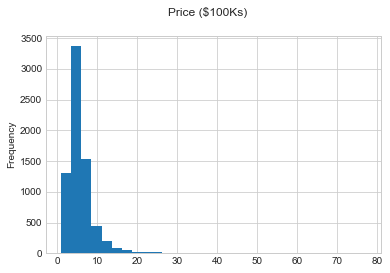

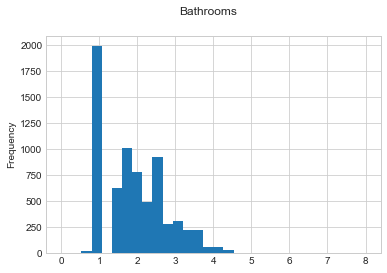

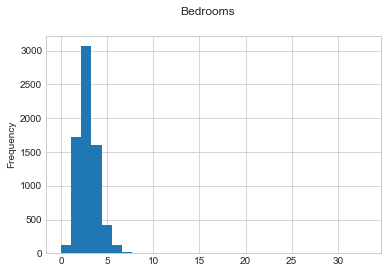

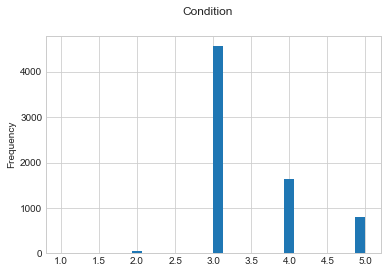

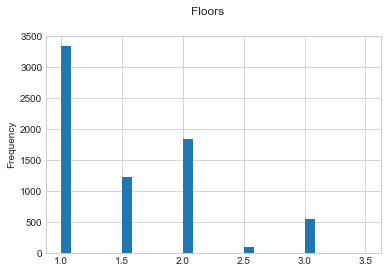

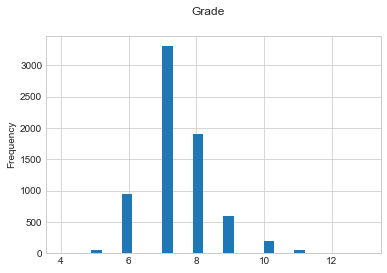

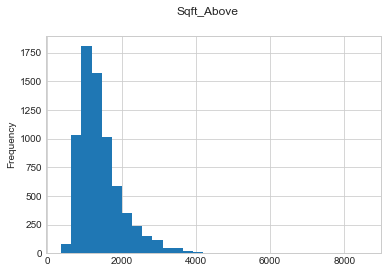

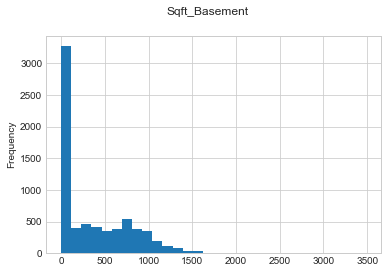

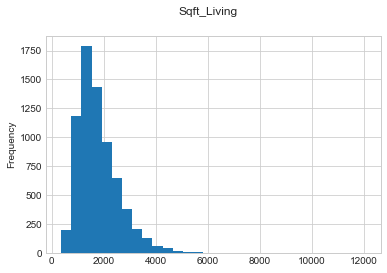

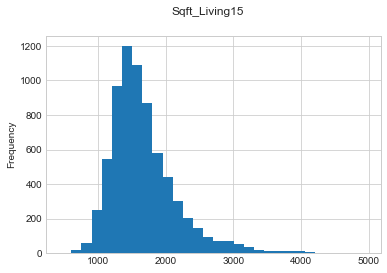

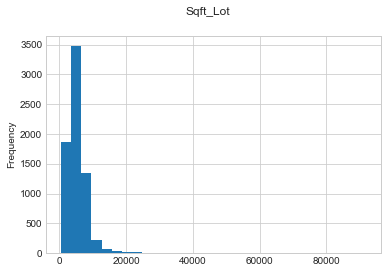

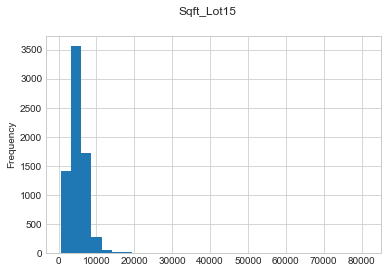

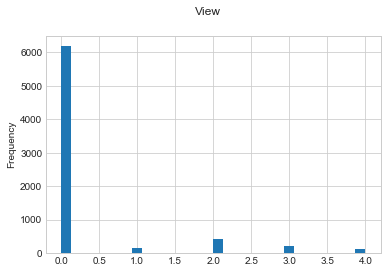

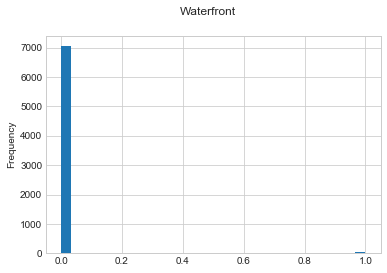

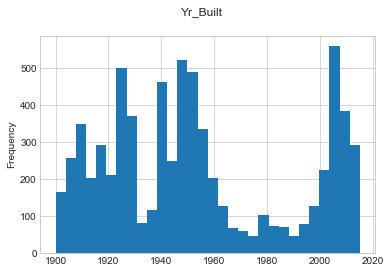

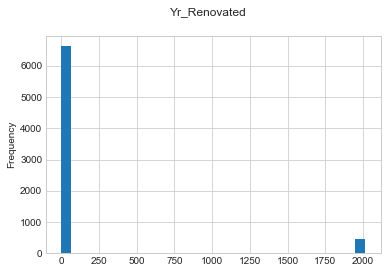

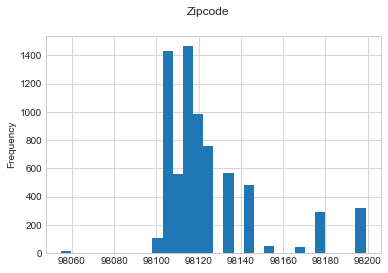

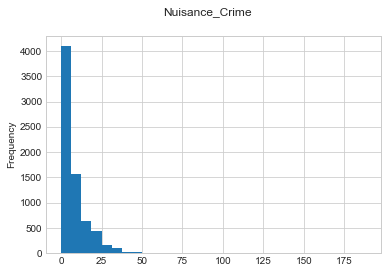

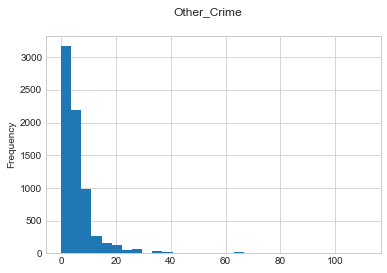

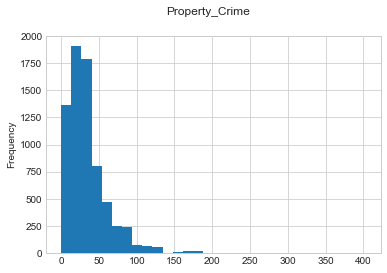

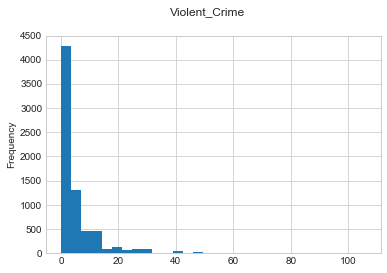

In [239]:
# Exploratory data visualization and feature selection
%matplotlib inline
# Plot histograms of the numeric variables
numeric_cols = ['Price', 'Bathrooms','Bedrooms', 'Condition', 'Floors', 'Grade',
                'Sqft_Above', 'Sqft_Basement', 'Sqft_Living', 'Sqft_Living15', 
                'Sqft_Lot', 'Sqft_Lot15', 'View', 'Waterfront', 'Yr_Built', 'Yr_Renovated',
                'Zipcode', 'Nuisance_Crime', 'Other_Crime', 'Property_Crime','Violent_Crime']
for col in numeric_cols:
    fig = plt.figure()
    if col == 'Price':
        temp = df.loc[:,""+col]/1e5 # scale to $100k
        temp.plot.hist(bins = 30)
        fig.suptitle(col + " ($100Ks)")
    else:
        df.loc[:,""+col].plot.hist(bins = 30)
        fig.suptitle(col)


In [240]:
# Drop obsolete variables. Have already gotten what I want from location and ID vars.
# Drop variables with rarefied distributions such as view, waterfront, year renovated
obsolete = ['Index', 'Id', 'Hexlat', 'Hexlong', 'Date', 'Zipcode', 'Waterfront',
            'View', 'Yr_Renovated'] # zipcode?
df = df.drop(obsolete, axis=1)

# Replace all outliers with NA. Outliers are more than 4SD away from mean
df = df.apply(replace_outliers_with_na)

#Drop the rows containing NA. We have 10K datapoints, no need to gap-fill
df = df.dropna(axis=0)

Price             1.000000
Bathrooms         0.472871
Bedrooms          0.363443
Condition         0.177966
Floors            0.227284
Grade             0.666332
Sqft_Above        0.658310
Sqft_Basement     0.373403
Sqft_Living       0.709527
Sqft_Living15     0.624176
Sqft_Lot          0.077596
Sqft_Lot15        0.037412
Yr_Built         -0.062197
Nuisance_Crime   -0.164365
Other_Crime      -0.147399
Property_Crime   -0.055644
Violent_Crime    -0.186351
Name: Price, dtype: float64
                Nuisance_Crime  Other_Crime  Property_Crime  Violent_Crime
Nuisance_Crime        1.000000     0.744401        0.737606       0.791038
Other_Crime           0.744401     1.000000        0.686275       0.736622
Property_Crime        0.737606     0.686275        1.000000       0.655296
Violent_Crime         0.791038     0.736622        0.655296       1.000000
               Sqft_Above  Sqft_Basement  Sqft_Living  Sqft_Living15  \
Sqft_Above       1.000000       0.119764     0.819551       0.4983

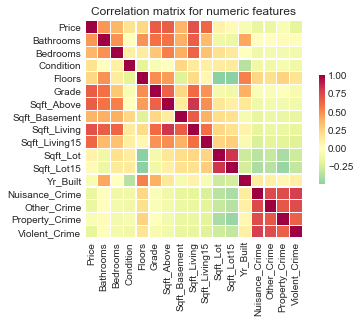

In [241]:
# All the data are numeric so let's plot their correlations
# The space-related variables, especilly Sqft* but to a lesser extent, # of bedrooms
# and bathrooms, are all inter-related and well correlated with price
# The crime variables are also inter-related, with negative but weaker correlation
# with price
numeric_corr = df.corr()

#plt.figure()
sns.heatmap(numeric_corr, vmax=1, center=0, 
            square=True, linewidths=.25, cbar_kws={"shrink": .5}, 
            cmap="Spectral_r")
plt.title('Correlation matrix for numeric features')
plt.yticks(rotation='horizontal')


# just look at price
print(numeric_corr.Price)

# if we add total crime how does that look
#df['Total_Crime'] = df[crimecols].sum(axis = 1)
#numeric_corr = df.corr()
#print(numeric_corr.Price)

# Correlations are fairly strong among different kinds of crime
# However the correlation with price varies so keep all 
cdf = df[crimecols]
print(cdf.corr())

# How are correlations among sqft variables?
sqft_cols = ['Sqft_Above','Sqft_Basement', 'Sqft_Living','Sqft_Living15',
             'Sqft_Lot', 'Sqft_Lot15', 'Floors']
print(df[sqft_cols].corr())

First attempt at OLS, including ALL variables.
Price ~ 1 + Bathrooms + Bedrooms + Condition + Floors + Grade + Sqft_Above + Sqft_Basement + Sqft_Living + Sqft_Living15 + Sqft_Lot + Sqft_Lot15 + Yr_Built + Nuisance_Crime + Other_Crime + Property_Crime + Violent_Crime
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     1108.
Date:                Mon, 28 May 2018   Prob (F-statistic):               0.00
Time:                        18:34:15   Log-Likelihood:                -89756.
No. Observations:                6756   AIC:                         1.795e+05
Df Residuals:                    6740   BIC:                         1.797e+05
Df Model:                          15                                         
Covariance Type:      

C:\Users\eowyn\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Text(0.5,1,'Residual Histogram')

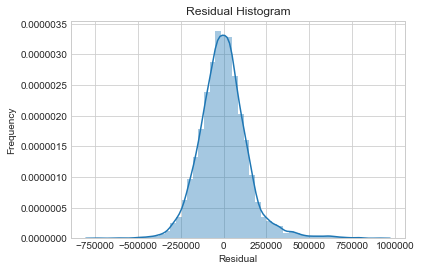

In [242]:
# At this point it is hard to move forward without some feature reduction
# We should start by creating a scaled dataset
target = df.Price
features = df.drop('Price', axis=1)
featcols = features.columns.tolist()
features = features.apply(scale)
df_scaled = features
df_scaled['Price'] = target
cols = df_scaled.columns.tolist()
cols = cols[-1:]+cols[:-1]
df_scaled = df_scaled[cols]

# Run a first-cut OLS model with all the variables to see which coefficients are statistically significant, and also
# put an upper limit on the metrics given all data and all features
formula = 'Price ~ 1'
for col in featcols:
    formula += ' + {}'.format(col)
    
print("First attempt at OLS, including ALL variables.")   
print(formula)

model1 = sm.ols(formula=formula, data=df_scaled)
results = model1.fit()
# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
plt.figure()
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

# AIC is huge and there is a warning about multicollinearties so we must reduce features

In [243]:
print('\nCompute the SVD and look at the singular values:')
U, s, V = np.linalg.svd(features, full_matrices=False)
print(s)
# 'Nuisance_Crime','Sqft_Lot', 'Sqft_Above'
# Drop cats with zero coeff/P val over 0.05. Drop Sqft metrics that are extremely correlated
#Drop other crime because results show that it is not a good predictor
obsolete = ['Other_Crime', 'Sqft_Basement', 'Sqft_Living15', 'Sqft_Lot15']
df_scaled = df_scaled.drop(obsolete, axis=1)
features = df_scaled.drop('Price', axis=1)
featcols = features.columns.tolist()
crimecols = ['Property_Crime','Violent_Crime','Nuisance_Crime']
cdf = df[crimecols]


Compute the SVD and look at the singular values:
[  5.04322119e+07   1.71920783e+02   1.58975712e+02   1.12899060e+02
   8.87936263e+01   7.68195885e+01   7.01652398e+01   6.61105694e+01
   5.08475918e+01   4.67242467e+01   4.64971722e+01   4.30854069e+01
   4.19169323e+01   3.78549071e+01   3.55161877e+01   3.34038196e+01
   2.82696876e-14]


In [244]:
# Make a model that is all the remaining variables    
formula = 'Price ~ 1'
for col in featcols:
    formula += ' + {}'.format(col)
#    
print(formula)

model1 = sm.ols(formula=formula, data=df_scaled)
results = model1.fit()
# Get most of the linear regression statistics we are interested in:
print("Drop highly-correlated. Does this eliminate colinearity warning?")
print(results.summary())

# OK that got rid of the multicollineary warning and slightly improved the AIC. 
######################################################################################################
# Try: SVD to identify number of PCAs.

print('\nCompute the SVD and look at the singular values:')
U, s, V = np.linalg.svd(features, full_matrices=False)
print(s)

Price ~ 1 + Bathrooms + Bedrooms + Condition + Floors + Grade + Sqft_Above + Sqft_Living + Sqft_Lot + Yr_Built + Nuisance_Crime + Property_Crime + Violent_Crime
Drop highly-correlated. Does this eliminate colinearity warning?
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     1229.
Date:                Mon, 28 May 2018   Prob (F-statistic):               0.00
Time:                        18:34:15   Log-Likelihood:                -90040.
No. Observations:                6756   AIC:                         1.801e+05
Df Residuals:                    6743   BIC:                         1.802e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                          

In [245]:
# The SVD wasn't super informative as it appears most of the variables are explaining a non-neglible chunk of variance.
# If you arbitrarily said, S>50 included, that would be 6. As a first cut, that's a good a choice as k as any for k-best means

# The coefficient on Floors meanwhile is not stat diff from zero (p>0.05, CI spans zero.)

# Here we implement a pair of algorithms to select features and test it out on the dataset

def k_best_model(features, target, k='all'):
    # Determine the numpy numerical values of the n best predictors
    temp_features = SelectKBest(f_classif, k).fit_transform(features, target)
    
    # Get the names of the n best predictors and stash in new_features
    mask = SelectKBest(f_classif, k).fit(features,target).get_support()
    feature_names = list(features.columns.values)
    new_feature_names = [] # The list of your K best features
    
    for bool, feature in zip(mask, feature_names):
        if bool:
            new_feature_names.append(feature)
    
    print(new_feature_names)
    formula = 'Price ~ 1'
    for col in new_feature_names:
        formula += ' + {}'.format(col)
        
    model1 = sm.ols(formula=formula, data=df_scaled)
    results = model1.fit()
    # Get most of the linear regression statistics we are interested in:
    print(results.summary())
    return results, new_feature_names, formula

# Try 5 features based on SVD. PCAs are linear combos of features, but, perhaps its a clue
k = 5 # number of features, see commentary above for rationale
print("K-Selected, k={}, all features".format(k))
k_best_model(features, target, k)    



def forward_selected(data, response, print_table=True):
    """Linear model designed by forward selection. Based on AIC

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data
    
    print_table: boolean, switch on/off OLS summary table printing (default On)

    Returns:
    --------
    results: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
    selected: a list of chosen variables
    formula: the OLS style formula of the model
    """
    # Start with no factors (intercept only)
    formula = "{} ~ 1".format(response)
    best_aic = sm.ols(formula, data).fit().aic
    
    
    # Go through remaining sets of variables one-by-one
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_aic = best_aic
    #print("AIC with all variables {:0.2f}".format(best_aic))
    
    # Check if any variables remain and if we haven't improved by adding any yet
    while remaining:
        aic_candidates = []
        for candidate in remaining:
            # Try adding the candidate column
            formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            # Get AIC
            aic = sm.ols(formula, data).fit().aic
            #print("Candidate: {}, AIC: {}".format(candidate, aic))
            # Append tuple of the form (aic, candidate)
            aic_candidates.append((aic, candidate))
        # Sort all the pairs by the first entry of tuple (default of sort() method)
        aic_candidates.sort()
        # Remember that the sort() method sorts by smallest to largest of first entry here.
        #   If you were to change the criteria to something that needs to be maximized, change sort/pop order!
        best_new_aic, best_candidate = aic_candidates.pop(0)
        # Now check if we have something better. If we do, add that to the model
        # if not, remove it from the candidate pool and go to the next canddiate feature
        #print("Comparing {} < {}".format(best_new_aic, current_aic))
        if best_new_aic < current_aic:
            #print("{} added to selected: {}".format(best_candidate, selected))
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_aic = best_new_aic
        else:
            break
        # Now we repeat the process with all the remaining candidate columns

    # Here is the final formula!
    formula = "{} ~ {} + 1".format(response, ' + '.join(selected))
    # Get the model object
    results = sm.ols(formula, data).fit()
    if print_table:
        print(results.summary())
    return results, selected, formula

print('Forward Selected, all features')
res, form, retained = forward_selected(df_scaled, 'Price')

K-Selected, k=5, all features
['Bathrooms', 'Bedrooms', 'Grade', 'Sqft_Above', 'Sqft_Living']
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     2054.
Date:                Mon, 28 May 2018   Prob (F-statistic):               0.00
Time:                        18:34:16   Log-Likelihood:                -90830.
No. Observations:                6756   AIC:                         1.817e+05
Df Residuals:                    6750   BIC:                         1.817e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [246]:
# Drop floors due to P>0.05
obsolete = ['Floors'] 
df_scaled = df_scaled.drop(obsolete, axis=1)
features = df_scaled.drop('Price', axis=1)
featcols = features.columns.tolist()

# Check that the model stats are not much impacted
print('Forward Selected, dropped floors')
model, retained, formula = forward_selected(df_scaled, 'Price')

Forward Selected, dropped floors
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     1340.
Date:                Mon, 28 May 2018   Prob (F-statistic):               0.00
Time:                        18:34:18   Log-Likelihood:                -90042.
No. Observations:                6756   AIC:                         1.801e+05
Df Residuals:                    6744   BIC:                         1.802e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept  

In [247]:
# We are now going to hone in on crime as an explanatory variable so let's see if we can detect the difference in metrics 
# when crime is excluded

print('Forward Selected, Excluding Crime')
model, retained, formula = forward_selected(df_scaled.drop(crimecols,axis=1), 'Price')
print(formula)

# Include total crime, in case it helps us simplify the analysis or reduce features
# Use a separate  dataframe to avoid co-linearities
print('Forward Selected, Including Total Crime only')
df2 = df.drop(crimecols, axis=1)
df2['Total_Crime'] = df[crimecols].sum(axis = 1)
df2_scaled = df_scaled.drop(crimecols,axis=1)
df2_scaled['Total_Crime'] = scale(df[crimecols].sum(axis = 1))
model, retained, formula = forward_selected(df2_scaled, 'Price')
print(formula)

Forward Selected, Excluding Crime
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     1765.
Date:                Mon, 28 May 2018   Prob (F-statistic):               0.00
Time:                        18:34:18   Log-Likelihood:                -90141.
No. Observations:                6756   AIC:                         1.803e+05
Df Residuals:                    6747   BIC:                         1.804e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.5

In [248]:
# Split the data into low and high property crime and violent crime
# High and Low are top 25% and lowest 25% respectively
pLo, pHi = np.percentile(df['Property_Crime'],[25,75])
low_p = df_scaled.loc[df['Property_Crime']<pLo,:]
high_p = df_scaled.loc[df['Property_Crime']>pHi,:]

pLo, pHi = np.percentile(df['Violent_Crime'],[25,75])
low_v = df_scaled.loc[df['Violent_Crime']<pLo,:]
high_v = df_scaled.loc[df['Violent_Crime']>pHi,:]

pLo, pHi = np.percentile(df['Nuisance_Crime'],[25,75])
low_n = df_scaled.loc[df['Nuisance_Crime']<pLo,:]
high_n = df_scaled.loc[df['Nuisance_Crime']>pHi,:]

pLo, pHi = np.percentile(df2['Total_Crime'],[25,75])
low_t = df2_scaled.loc[df2['Total_Crime']<pLo,:]
high_t = df2_scaled.loc[df2['Total_Crime']>pHi,:]

####################################################
# Set aside 10% of the data altogether before training models
# This is a set up for cross-validation

# X is the remaining data, XX is the validation data, Y is the remaining-target
# and YY is the validation target
# Low Crime
XLval, XXLval, YLval, YYLval = train_test_split(low_t.drop('Price',axis=1),
                                    low_t.Price, random_state=0,
                                    test_size=0.1)
# High Crime
XHval, XXHval, YHval, YYHval = train_test_split(high_t.drop('Price',axis=1),
                                    high_t.Price, random_state=0,
                                    test_size=0.1)

# Split into test/train datasets: Total Crime Only
r = 0.2 # percent data set aside to test

# X is the training data, XX is the test data, Y is the training-target
# and YY is the testing-target
# Low Crime
XL, XXL, YL, YYL = train_test_split(XLval,
                                    YLval, random_state=0,
                                    test_size=r)
# Outer join to append Price column in order to test OLS-based models
ZL, ZZL = pd.concat([XL,YL], axis=1), pd.concat([XXL,YYL], axis=1)
# High Crime
XH, XXH, YH, YYH = train_test_split(XHval,
                                    YHval, random_state=0,
                                    test_size=r)
# Outer join to append Price column in order to test OLS-based models
ZH, ZZH = pd.concat([XH,YH], axis=1), pd.concat([XXH,YYH], axis=1)

In [249]:
# Construct separate models and use them to predict price of same house. This is based on ALL the data. 
# Later we will train test and validate models on subsets of the data

#print('Low Nuisance Crime')
lownmodel, lownnames, lownform = forward_selected(low_n, 'Price', print_table=False)

#print('High Nuisance Crime')
highnmodel, highnnames, highnform = forward_selected(high_n, 'Price', print_table=False)

#print('Low Property Crime')
lowpmodel, lowpnames, lowpform = forward_selected(low_p, 'Price', print_table=False)

#print('High Property Crime')
highpmodel, highpnames, highpform = forward_selected(high_p, 'Price', print_table=False)

#print('Low Violent Crime')
lowvmodel, lowvnames, lowvform = forward_selected(low_v, 'Price', print_table=False)

#print('High Violent Crime')
highvmodel, highvnames, highvform = forward_selected(high_v, 'Price', print_table=False)

print('Low Total Crime')
lowtmodel, lowtnames, lowtform = forward_selected(low_t, 'Price')

print('High Total Crime')
hightmodel, hightnames, hightform = forward_selected(high_t, 'Price')

# Same House Comparison
house1050 = df_scaled.iloc[1050]

inputs = [1] + [house1050[lown] for lown in lownnames]
costlown = lownmodel.predict(inputs, transform=False)
inputs = [1] + [house1050[highn] for highn in highnnames]
costhighn = highnmodel.predict(inputs, transform=False)
print("Same house costs ${:.0f} in low nuisance crime area and ${:.0f} in high nuisance crime area"
      .format(costlown[0], costhighn[0]))


inputs = [1] + [house1050[lowp] for lowp in lowpnames]
costlowp = lowpmodel.predict(inputs, transform=False)
inputs = [1] + [house1050[highp] for highp in highpnames]
costhighp = highpmodel.predict(inputs, transform=False)
print("Same house costs ${:.0f} in low property crime area and ${:.0f} in high property crime area"
      .format(costlowp[0], costhighp[0]))

inputs = [1] + [house1050[lowv] for lowv in lowvnames]
costlowv = lowvmodel.predict(inputs, transform=False)
inputs = [1] + [house1050[highv] for highv in highvnames]
costhighv = highvmodel.predict(inputs, transform=False)
print("Same house costs ${:.0f} in low violent crime area and ${:.0f} in high violent crime area"
      .format(costlowv[0], costhighv[0]))

house1050 = df2_scaled.iloc[1050] # use DF2 for total-crime

inputs = [1] + [house1050[lowt] for lowt in lowtnames]
costlowt = lowtmodel.predict(inputs, transform=False)
inputs = [1] + [house1050[hight] for hight in hightnames]
costhight = hightmodel.predict(inputs, transform=False)
print("Same house costs ${:.0f} in low total crime area and ${:.0f} in high total crime area"
      .format(costlown[0], costhight[0]))

Low Total Crime
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     465.6
Date:                Mon, 28 May 2018   Prob (F-statistic):               0.00
Time:                        18:34:25   Log-Likelihood:                -21180.
No. Observations:                1571   AIC:                         4.238e+04
Df Residuals:                    1561   BIC:                         4.243e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7.096e+05   2.51e+04 

In [250]:
# Compare the average price and square footage depending on crime density
print('-'*40)
print("Ave price in low total crime areas: {:.0f}".format(np.mean(low_t.Price)))
print("Ave price in high total crime areas: {:.0f}".format(np.mean(high_t.Price)))

print('-'*40)
print("Ave price in low nuisance crime areas: {:.0f}".format(np.mean(low_n.Price)))
print("Ave price in high nuisance crime areas: {:.0f}".format(np.mean(high_n.Price)))

print('-'*40)
print("Ave price in low prop crime areas: {:.0f}".format(np.mean(low_p.Price)))
print("Ave price in high prop crime areas: {:.0f}".format(np.mean(high_p.Price)))

print('-'*40)
print("Ave price in low violent crime areas: {:.0f}".format(np.mean(low_v.Price)))
print("Ave price in high violent crime areas: {:.0f}".format(np.mean(high_v.Price)))

print('-'*40)
print("Ave scaled Sqft_Living in low total crime areas: {:.3f}".format(np.mean(low_t.Sqft_Living)))
print("Ave scaled Sqft_Living in high total crime areas: {:.3f}".format(np.mean(high_t.Sqft_Living)))

print('-'*40)
print("Ave scaled Sqft_Living in low nuisance crime areas: {:.3f}".format(np.mean(low_n.Sqft_Living)))
print("Ave scaled Sqft_Living in high nuisance crime areas: {:.3f}".format(np.mean(high_n.Sqft_Living)))

print('-'*40)
print("Ave scaled Sqft_Living in low prop crime areas: {:.3f}".format(np.mean(low_p.Sqft_Living)))
print("Ave scaled Sqft_Living in high prop crime areas: {:.3f}".format(np.mean(high_p.Sqft_Living)))

print('-'*40)
print("Ave scaled Sqft_Living in low violent crime areas: {:.3f}".format(np.mean(low_v.Sqft_Living)))
print("Ave scaled Sqft_Living in high violent crime areas: {:.3f}".format(np.mean(high_v.Sqft_Living)))

----------------------------------------
Ave price in low total crime areas: 614446
Ave price in high total crime areas: 501778
----------------------------------------
Ave price in low nuisance crime areas: 610557
Ave price in high nuisance crime areas: 489405
----------------------------------------
Ave price in low prop crime areas: 600527
Ave price in high prop crime areas: 518343
----------------------------------------
Ave price in low violent crime areas: 605760
Ave price in high violent crime areas: 456274
----------------------------------------
Ave scaled Sqft_Living in low total crime areas: 0.312
Ave scaled Sqft_Living in high total crime areas: -0.248
----------------------------------------
Ave scaled Sqft_Living in low nuisance crime areas: 0.311
Ave scaled Sqft_Living in high nuisance crime areas: -0.257
----------------------------------------
Ave scaled Sqft_Living in low prop crime areas: 0.268
Ave scaled Sqft_Living in high prop crime areas: -0.243
-----------------

At first exploration, the PRICE of housing is a lot higher in low crime areas (especially violent crime and nuisance crime)... but the houses themselves are also very different, with more living space. I will explore this in detail in the next section with hypothesis tests and visualizations.

From this point onwards, in the interest of simplicity, I am going to use total crime only
Plus this removes the effect of any collinearties, while maintaining the best R2 and lowest AIC

In [251]:
# One hot encode the high crime, low crime to look at how various other features relate to crime-density
# I suspect that the reason the crime/price signal is difficult to tease out is that other features are also varying
# with the crime density of the neighborhood

df3_scaled = deepcopy(df2_scaled) # make a dataframe for these tests and plots
pLo, pHi = np.percentile(df2['Total_Crime'],[25,75]) # Note that pLo and pHi are 21, 49
df3_scaled.loc[df2['Total_Crime']<pLo, 'High_Crime'] = 0
df3_scaled.loc[df2['Total_Crime']>pHi, 'High_Crime'] = 1
df3_scaled = df3_scaled.dropna(axis=0)  # Drop the middle-crime houses to focus on high/low
print(df3_scaled.head())
print(df3_scaled.shape)

       Price  Bathrooms  Bedrooms  Condition     Grade  Sqft_Above  \
2   487000.0   0.791296  0.931632  -0.628631  1.733284    2.134743   
4   520000.0   0.141090 -0.111129   0.784220 -0.377399    0.025775   
6   630000.0  -1.159323  1.974393  -0.628631 -0.377399    3.030588   
9   130000.0  -1.159323 -0.111129   0.784220 -0.377399   -0.552791   
10  319500.0   1.116399  0.931632   0.784220 -0.377399    0.044439   

    Sqft_Living  Sqft_Lot  Yr_Built  Total_Crime  High_Crime  
2      1.107133 -0.023007  1.496397    -1.129464         0.0  
4     -0.475495 -0.881871 -1.489095     1.365742         1.0  
6      1.779400 -0.098032 -1.518080     2.845458         1.0  
9     -0.909667  0.013945 -1.170256    -0.897352         0.0  
10     1.051111  0.013945 -1.344168    -0.897352         0.0  
(3247, 11)


In [252]:
def group_conditioned(df, column, pvar):
    # Return groups and list of pvar data grouped by column for use in f-test and tukey tests
    print('Conditioning on: {}'.format(column))
    choices = df.loc[:,column].unique()

    # Create groups based on these stratifications. USE A DICTIONARY
    d = {}
    groups = []
    valid_choices = []
    for choice in choices:
        x = df.loc[df.loc[:, column] == choice, pvar]  # DATA for this group
        print("{0} entries in {1}".format(len(x), choice))  
        if len(x) < 10:
            print("Not including {} as it has fewer than 10 entries".format(choice))
            continue     
            
        d["{0}".format(choice)] = x # Assign data to dictionary object named for this style
        groups += len(x)* ["{0}".format(choice)]  # Record the groups for these entries to use later
        #valid_choices.append(choice)
        
    print("The keys in my dictionary are: " + ','.join([k for k in d.keys()]))    
    valid_choices = [k for k in d.keys()]
    result = [d[valid_c] for valid_c in valid_choices] # sometimes, maybe, ""+valid_c
    return(groups, result)


def print_tests_bootstrap_CI(df, column, pvar, alpha):
    # Print the results of ANOVA, Tukey-Pairwise, and bootstrap CI tests
    # First, Classical f-test (anova) in which we also create our groups and drop any with two few entries (<10)
    groups, d = group_conditioned(df, column, pvar) 
    f_statistic, p_value = ss.f_oneway(*d)  # *d unpacks the list into series for the f_oneway function
    print('F statistic = ' + str(f_statistic))
    print('P-value = ' + str(p_value))

    # Second, do a Tukey HSD test on the groups. Why won't the figure show?
    tdf = np.concatenate(d).flatten()
    %matplotlib inline
    Tukey_HSD = pairwise_tukeyhsd(tdf, groups)
    plt.show()
    print(Tukey_HSD)

    # Third, bootstrap the difference of means and if the CI encompasses 0, cannot reject null hypothesis
    n_replicas = 1000
    print("Alpha:{}".format(alpha))
    bootstrap_diff_means = pd.Series([d[0].sample(frac=1, replace=True).mean() - d[1].sample(frac=1, replace=True).mean()
                                 for i in range(n_replicas)])
    lower_ci = np.percentile(bootstrap_diff_means, alpha/2.)
    upper_ci = np.percentile(bootstrap_diff_means, 100-alpha/2.)
    print("The CI on bootstrap diff ({} - {}) mean of {} is {}:{}".format("Low Crime", "High Crime", pvar ,lower_ci, upper_ci))

--------------------Price, Scaled--------------------
Conditioning on: High_Crime
1571 entries in 0.0
1676 entries in 1.0
The keys in my dictionary are: 0.0,1.0
F statistic = 135.045751849
P-value = 1.29220640039e-30
    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
group1 group2   meandiff     lower        upper    reject
---------------------------------------------------------
 0.0    1.0   -112667.863 -131677.3196 -93658.4064  True 
---------------------------------------------------------
Alpha:0.05
The CI on bootstrap diff (Low Crime - High Crime) mean of Price is 81613.64694284511:144806.63233730046


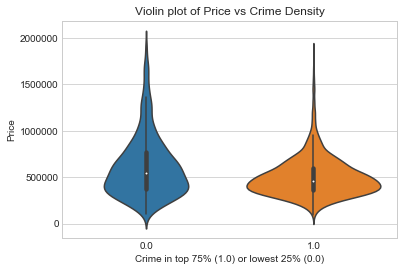

--------------------Bathrooms, Scaled--------------------
Conditioning on: High_Crime
1571 entries in 0.0
1676 entries in 1.0
The keys in my dictionary are: 0.0,1.0
F statistic = 3.96582646456
P-value = 0.046516421395
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    1.0   -0.0701  -0.1391 -0.0011  True 
---------------------------------------------
Alpha:0.05
The CI on bootstrap diff (Low Crime - High Crime) mean of Bathrooms is -0.04277749724119713:0.17565397867267227


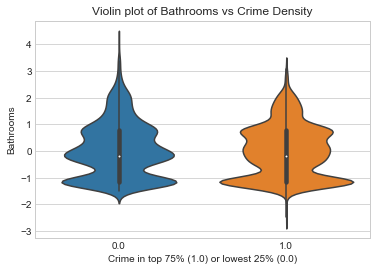

--------------------Bedrooms, Scaled--------------------
Conditioning on: High_Crime
1571 entries in 0.0
1676 entries in 1.0
The keys in my dictionary are: 0.0,1.0
F statistic = 78.7317446067
P-value = 1.15189713513e-18
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    1.0   -0.3001  -0.3664 -0.2338  True 
---------------------------------------------
Alpha:0.05
The CI on bootstrap diff (Low Crime - High Crime) mean of Bedrooms is 0.18822733184264123:0.3956668028745208


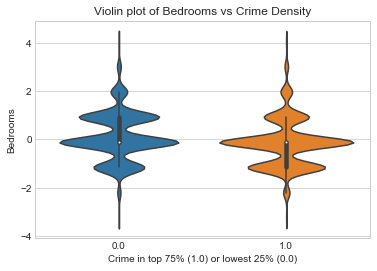

--------------------Condition, Scaled--------------------
Conditioning on: High_Crime
1571 entries in 0.0
1676 entries in 1.0
The keys in my dictionary are: 0.0,1.0
F statistic = 35.6680469779
P-value = 2.59277255516e-09
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    1.0   -0.2059  -0.2735 -0.1383  True 
---------------------------------------------
Alpha:0.05
The CI on bootstrap diff (Low Crime - High Crime) mean of Condition is 0.09408075198197104:0.3081800332802663


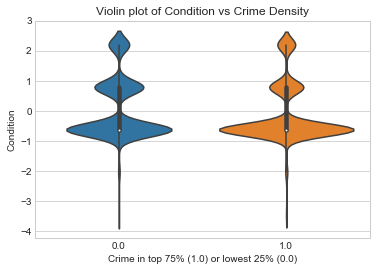

--------------------Grade, Scaled--------------------
Conditioning on: High_Crime
1571 entries in 0.0
1676 entries in 1.0
The keys in my dictionary are: 0.0,1.0
F statistic = 40.4378728606
P-value = 2.31393850504e-10
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    1.0    -0.229  -0.2997 -0.1584  True 
---------------------------------------------
Alpha:0.05
The CI on bootstrap diff (Low Crime - High Crime) mean of Grade is 0.1085407724124565:0.33946506588359143


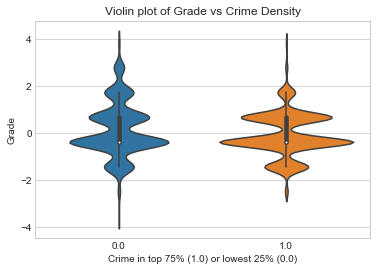

--------------------Sqft_Above, Scaled--------------------
Conditioning on: High_Crime
1571 entries in 0.0
1676 entries in 1.0
The keys in my dictionary are: 0.0,1.0
F statistic = 109.429965776
P-value = 3.27435380467e-25
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    1.0   -0.3639  -0.4321 -0.2957  True 
---------------------------------------------
Alpha:0.05
The CI on bootstrap diff (Low Crime - High Crime) mean of Sqft_Above is 0.25589194690178196:0.5011730524916076


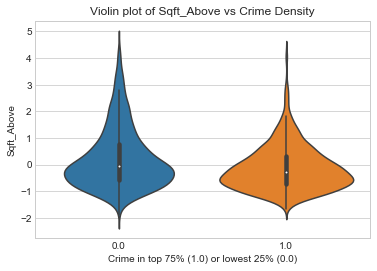

--------------------Sqft_Living, Scaled--------------------
Conditioning on: High_Crime
1571 entries in 0.0
1676 entries in 1.0
The keys in my dictionary are: 0.0,1.0
F statistic = 267.806789324
P-value = 6.68990371006e-58
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    1.0   -0.5599  -0.6269 -0.4928  True 
---------------------------------------------
Alpha:0.05
The CI on bootstrap diff (Low Crime - High Crime) mean of Sqft_Living is 0.4536012995534736:0.6806124397663592


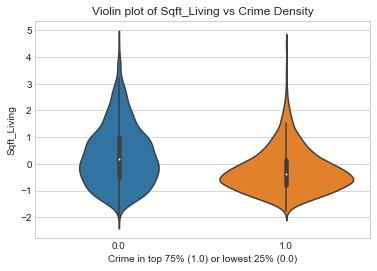

--------------------Sqft_Lot, Scaled--------------------
Conditioning on: High_Crime
1571 entries in 0.0
1676 entries in 1.0
The keys in my dictionary are: 0.0,1.0
F statistic = 1323.90449514
P-value = 2.06872396613e-243
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    1.0   -1.1942  -1.2586 -1.1299  True 
---------------------------------------------
Alpha:0.05
The CI on bootstrap diff (Low Crime - High Crime) mean of Sqft_Lot is 1.1023600324365888:1.3063635175975339


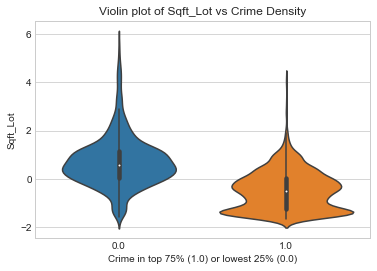

--------------------Yr_Built, Scaled--------------------
Conditioning on: High_Crime
1571 entries in 0.0
1676 entries in 1.0
The keys in my dictionary are: 0.0,1.0
F statistic = 13.9146599812
P-value = 0.000194573745113
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
 0.0    1.0    0.1302  0.0618 0.1986  True 
-------------------------------------------
Alpha:0.05
The CI on bootstrap diff (Low Crime - High Crime) mean of Yr_Built is -0.24108832779438555:-0.015681114487073197


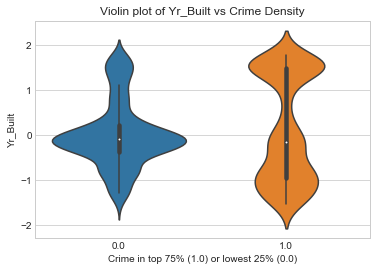

In [253]:
# ANOVA, Tukey HSD, and Boostrap Difference of Means Tests for all features except crime ones
alpha = 0.05
pvars = list(df3_scaled)[:-2]
column = 'High_Crime'
i=0
for pvar in pvars:
    print(20*'-'+ pvar + ', Scaled' + 20*'-')
    print_tests_bootstrap_CI(df3_scaled, column, pvar, alpha)    
    # I'm bummed the Tukey plots are not generating, so I am inserting Violin plots to visualize the relative distributions
    fig = plt.figure(i) # define plot area
    ax = fig.gca() # define axis 
    sns.set_style("whitegrid")
    sns.violinplot(x = 'High_Crime', y = pvar, data = df3_scaled, ax = ax)
    ax.set_title('Violin plot of {} vs Crime Density'.format(pvar)) # Give the plot a main title
    ax.set_xlabel('Crime in top 75% (1.0) or lowest 25% (0.0)') # Set text for the x axis
    ax.set_ylabel(pvar)# Set text for y axis
    plt.show()
    i += 1

The houses on low crime blocks (vs high crime) have similar numbers of bathrooms, but in all other respects are different. They are significantly more expensive. They have significantly greater number of bedrooms, livable square footage, lot size (lot size is a LOT bigger in low-crime areas), better condition, higher grade, and were built earlier. Considering how the big, nice houses in Seattle are mostly older, I'm not surprised these features are clustering in some neighborhoods vs others, and that those neighborhoods have less crime overall. 

Note that the Tukey test would suggest rejecting the null hypothesis of "same means" on bathrooms but the bootstrap CI spans zero, and the Tukey test is just barely reaching significance, so this and the figures make me unwilling to reject the null hypothesis for bathrooms. For simlar reasons, I rejected it for all the other features. 

I'd hazard a guess that the # of bathrooms being statistically similar is because newer construction tends to follow the one bathroom per bedroom model, whereas older construction had fewer bathrooms centered around the central plumbing lines. So as time went on developers scaled down the number of bedrooms but kept or increased the number of bathrooms. The homes in New England typify this trend in time; it is pretty common to have 4-bd homes built in 1910 with just one, maybe two bathrooms.

The violin plots are interesting too. For the discrete variables (# rooms, # bathrooms, condition) the distributions are similar for the low and high crime areas. The price and square footage above distributions look simlar to one another, that is, the low crime vs high crime shapes look similar; you could swap out the titles and not be sure which is which. The square foot living is similar on the high crime side, but the low crime sidehas a more spread out distribution. The lot size is interesting, with the low crime houses clearly having higher lot size on average and a distribution shift further right overall than the high crime houses. The yr-built is bifurcated, with the low crime houses being predominantly median age and the high-crime houses being split between very old and very new, albeit with a significant number in the middle. More of those are very new than very old. And there is a secondary peak in the low crime areas with very new homes as well. 

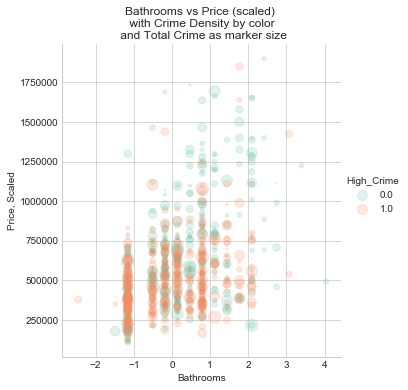

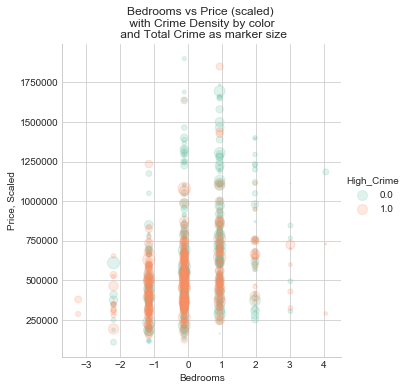

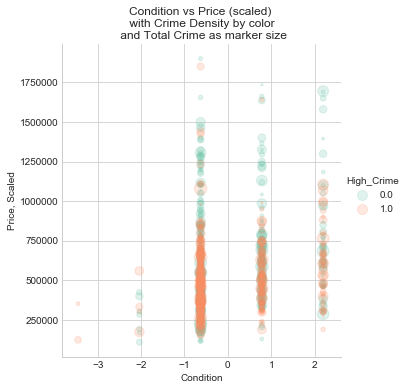

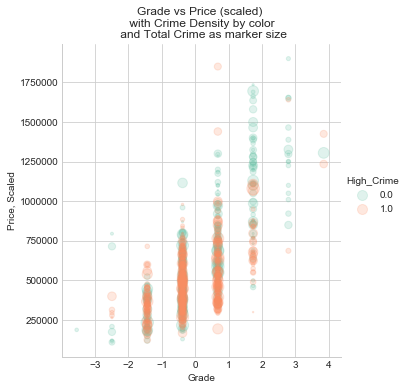

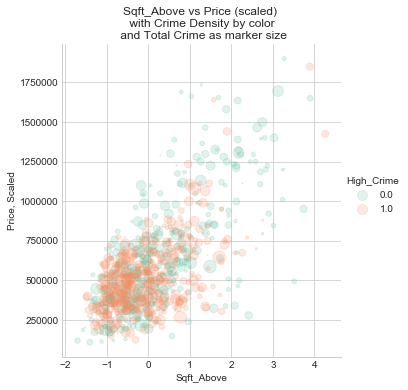

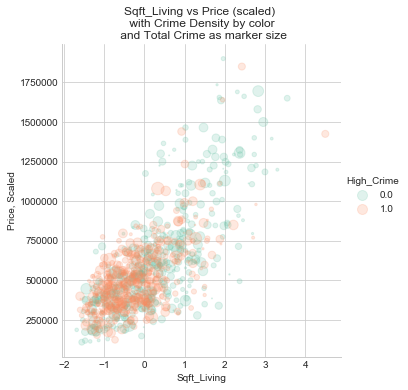

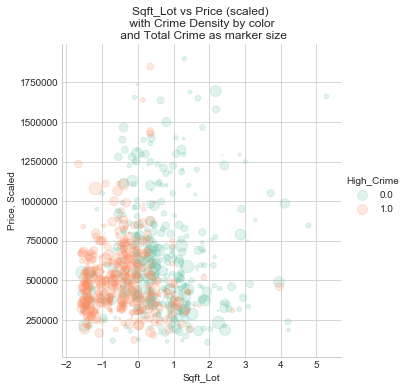

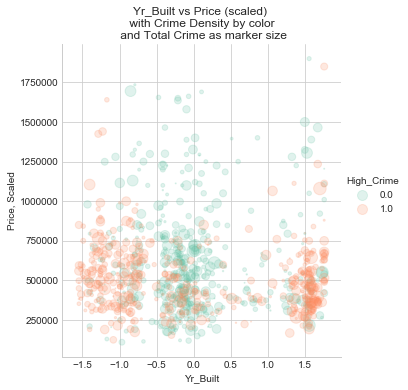

In [254]:
# Visualize the relationships with house characteristics, price, and crime
# Work on a random subset to make figures easier to read
import random
random.seed(560)
tempdf = df3_scaled.sample(frac=0.3)
%matplotlib inline
pvars = list(df3_scaled)[1:-2] # Exclude price, and crime
for pvar in pvars:
    sns.lmplot(x = pvar, y = 'Price', 
               data = tempdf, 
               hue = "High_Crime",
               palette="Set2", 
               scatter_kws={'s': df2.Total_Crime, 'alpha': 0.2},
               fit_reg = False)
    plt.xlabel(pvar)
    plt.ylabel('Price, Scaled')
    plt.title(pvar+ ' vs Price (scaled) \n with Crime Density by color \n and Total Crime as marker size')

Several interesting relationships are visible in these plots. In each plot, price is on the y-axis, and the scaled features (# Bathrooms, Yr Built, Square footage, lot size, etc) are on the x-axis. The orange dots are for high crime blocks and the green dots are for low crime blocks, and the dots themselves are sized according to the total crime amount, so a large orange dot is a very crime-y block and a small green dot is very safe. Based on the Tukey, ANOVA, and bootstrap CI tests, we expect the # of bathrooms to look pretty similar regardless of crime density, while we expect yr built to be higher for low-crime, and other features to be lower for low crime. But these figures give us quite a bit more detail. The bathroom #s are pretty indistiguishable, and there are a lot of cheaper houses in high crime areas with few bathrooms. There are also many cheaper houses in high crime areas with fewer bedrooms than average -- but then again, there are houses with the same # of bedrooms that are much more costly in low crime areas. Condition is similar to bedrooms - there are plenty of houses in good shape and bad shape in both high and low criem areas, but the low crime ones cost quite a bit more even at the same condition class. 

The more continuous variables - square footage, lot size, yr built - are interesting too. Living area and living area above behave similarly, with a linearly upward trend between square footage and price. There are a lot of more affordable, smaller houses in both low and high crime areas, but the biggest most expensive houses tend to be in low crime areas. Though there are handful of big expensive houses in high-crime areas, which makes me wonder if 2013 was an anomaly in crime for those places? The data we have can't answer that question, we'd need multi-year data. Of note, teh square footage and lot size variables having a linear relationship with price is probably why they're such good linear predictors... and the other variables *not* having that relationship form means a linear model is unlikely to consider them good predictors.

Lot size vs price and yr-built vs price are more clustered. The results reflect what we saw in the volin plots and tukey tests above. The high crime blocks predominantly have small (below the mean) lots, and the low crime blocks predominantly have lotsize greater than the mean. Yr-Built is bifurcated: many of the houses in high-crime areas are either very old or very new, and there's a lot more average yr-built homes in the low-crime areas. That said, notice that there is a collection of low-crime, newer homes that are commanding higher prices. But it doesn't look like there's enough of them to figure heavily in a linear model. 

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     353.9
Date:                Mon, 28 May 2018   Prob (F-statistic):          4.09e-320
Time:                        18:34:35   Log-Likelihood:                -15234.
No. Observations:                1130   AIC:                         3.049e+04
Df Residuals:                    1120   BIC:                         3.054e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7.074e+05   2.96e+04     23.873      

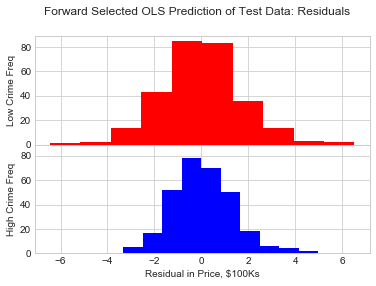

In [255]:
# Model improvements! Models will be compared based on their metrics (primarily MAE, same units as price)
# relative to unseen data. 

# Test the forward-selected OLS models on unseen data to generate accuracy measures 
mod,_,_ = forward_selected(ZL, 'Price', print_table=True)
y_pred = mod.predict(XXL) 
mae = mean_absolute_error(y_pred, YYL)
mse = mean_squared_error(y_pred,YYL)
r2 = r2_score(y_pred,YYL)
resid_low = YYL - y_pred
print("Low Crime Fwd Selected OLS: \n MAE: {:.0f} \n MSE: {:.0f} \n R^2: {:.3f}"
      .format(mae, mse, r2))

mod,_,_ = forward_selected(ZH, 'Price', print_table=True) # Change to False
y_pred = mod.predict(XXH)
mae = mean_absolute_error(y_pred, YYH)
mse = mean_squared_error(y_pred,YYH)
r2 = r2_score(y_pred,YYH)
resid_high = YYH - y_pred
print("High Crime Fwd Selected OLS: \n MAE: {:.0f} \n MSE: {:.0f} \n R^2: {:.3f}"
      .format(mae, mse, r2))

# Combined plot of residuals
f, axarr = plt.subplots(2, sharex=True, sharey=True)
f.suptitle('Forward Selected OLS Prediction of Test Data: Residuals')
axarr[0].hist(resid_low/1e5, color='red')
axarr[1].hist(resid_high/1e5, color='blue')
f.subplots_adjust(hspace=0)
axarr[0].grid(True)
axarr[0].set_ylabel('Low Crime Freq')
axarr[1].grid(True)
axarr[1].set_ylabel('High Crime Freq')
for ax in axarr.flat:
    ax.set(xlabel='Residual in Price, $100Ks')

The residuals are nice and normal, and I log the MAE for choosing models later.

In [256]:
# Elasticnet Regsion with a sequence of lambdas
# Generate a sequence of lambdas
log_lambda_seq = np.linspace(-6, 0, 50)
lambda_seq = np.exp(log_lambda_seq)

def fit_ridge_model(informula, df, target):
    '''
    Fit a combined lasso/ridge model in order to optimize the hyperparamters
    of our OLS models. Use the elastic net method and optimize on maximizing R^2.
    Return statsmodel model object. target should be like low_t.Price
    df should contain all scaled features and target
    '''
    coeffs_array = []
    rsq_array = []
    mx_rsq = 0
    for lamb in lambda_seq:
        ridge_model = sm.ols(formula=informula, data=df).fit_regularized(method='elastic_net', 
                            alpha=lamb, L1_wt=0.75)
        coeffs_array.append(list(ridge_model.params))
        predictions = ridge_model.fittedvalues
        residuals = [x - y for x, y in zip(np.squeeze(predictions), target)]
    
        SSR = np.sum(np.square(residuals))
        SST = np.sum(np.square(target - np.mean(target))) 
        rsq = 1 - (SSR / SST)
        rsq_array.append(rsq)
        if rsq > mx_rsq:
            mx_rsq = rsq
            mx_alpha = lamb
    print("Max Rsq {:0.2f} achieved with lambda = {:0.4f}".format(mx_rsq, mx_alpha))
    # NB: I tested manually with a selection of L1_wts and Rsq wasn't sensitive to L1_wt
    
    beta_coeffs = [x[1:] for x in coeffs_array]
    plt.figure()
    plt.plot(log_lambda_seq, beta_coeffs)
    plt.title('Partial Slopes vs Log-Lambda')
    plt.ylabel('Partial Slope Values')
    plt.xlabel('Log-Lambda')
    plt.legend(loc='upper right')
    plt.show()
   
    
    # Plot partial slopes vs R squared (% deviance explained)
    plt.figure()
    plt.plot(rsq_array, beta_coeffs)
    #plt.xlim([0.5, 0.75])
    plt.title('Partial Slopes vs R-squared')
    plt.xlabel('R-squared')
    plt.ylabel('Partial Slopes')
    plt.legend(loc='upper right')
    
    ridge_model = sm.ols(formula=informula, data=df).fit_regularized(method='elastic_net', 
                            alpha=mx_alpha, L1_wt=0.75)
    return ridge_model

Max Rsq 0.72 achieved with lambda = 0.0025


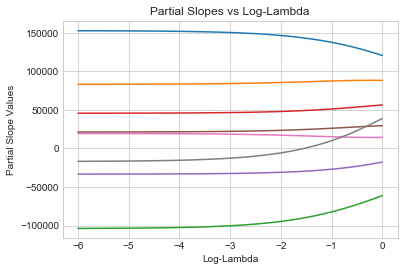

Max Rsq 0.60 achieved with lambda = 0.0025


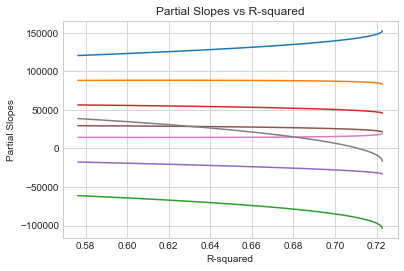

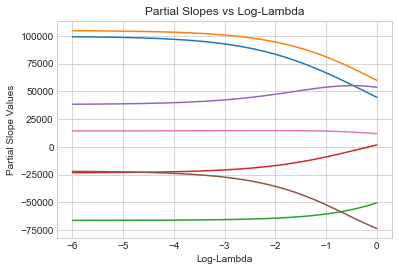

Low Crime Model Parameters:
Intercept      566467.076652
Grade          152654.710603
Sqft_Living     83190.083454
Yr_Built      -103756.836263
Sqft_Above      45694.944651
Bedrooms       -33310.577724
Condition       21321.806944
Bathrooms       19380.890859
Sqft_Lot       -16721.738073
dtype: float64
High Crime Model Parameters:
Intercept      534095.091169
Sqft_Living     99211.428218
Grade          104627.871898
Yr_Built       -66319.644194
Bedrooms       -23377.078364
Sqft_Above      38368.712383
Sqft_Lot       -22142.442029
Condition       14357.628158
dtype: float64


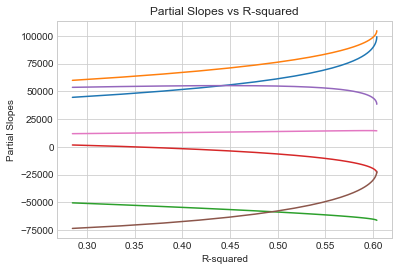

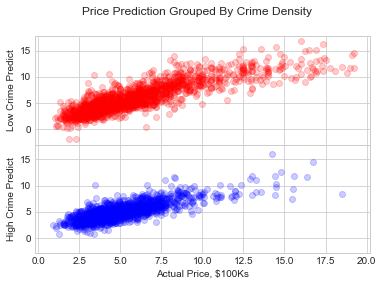

In [257]:
# Decide: drop crime from model at this stage? 
# Yes: It appears to be making the model much too volatile PLUS (perhaps because?) price is 
# already baked in via the grouping. Theory: collinarities introducing instability
lowtform = 'Price ~ Grade + Sqft_Living + Yr_Built  + Sqft_Above + Bedrooms + Condition + Bathrooms + Sqft_Lot + 1'
low_ridge_model = fit_ridge_model(lowtform, low_t, low_t.Price)
hightform = 'Price ~ Sqft_Living + Grade + Yr_Built + Bedrooms + Sqft_Above + Sqft_Lot + Condition + 1'
high_ridge_model = fit_ridge_model(hightform, high_t, high_t.Price)

# Plot
# Get slope (m) and y-intercept (b)
print('Low Crime Model Parameters:\n{}'.format(low_ridge_model.params))
y_pred_low = low_ridge_model.predict(low_t.drop('Price', axis=1))
print('High Crime Model Parameters:\n{}'.format(high_ridge_model.params))
y_pred_high = high_ridge_model.predict(high_t.drop('Price', axis=1))

# Plot result of both on shared axis
plt.figure()
f, axarr = plt.subplots(2, sharex=True, sharey=True)
f.suptitle('Price Prediction Grouped By Crime Density')
axarr[0].scatter(low_t.Price/1e5, y_pred_low/1e5, alpha=0.2, color='red')
axarr[1].scatter(high_t.Price/1e5, y_pred_high/1e5, alpha=0.2, color='blue')
f.subplots_adjust(hspace=0)
axarr[0].grid(True)
axarr[0].set_ylabel('Low Crime Predict')
axarr[1].grid(True)
axarr[1].set_ylabel('High Crime Predict')
for ax in axarr.flat:
    ax.set(xlabel='Actual Price, $100Ks')


The partial slopes plots lead me to discard crime from among the predictors for the Lasso Ridge models because it was introducing signifcant instability to the lambda; the partial slope was varying wildly across the range of r-squareds. Having done so the model parameters are presented and the predictions are plotted against price. The high crime areas have fewer homes at high actual price. In both cases, the predicted price is overestimating the actual price (note the x axis ranges 0--20, while the y axis ranges 0--15, and at say \$500K predicted price, the actual price is closer to \$250K).

Max Rsq 0.73 achieved with lambda = 0.0025


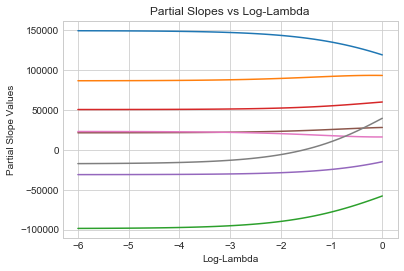

Low Crime Tuned Lasso/Ridge: 
 MAE: 132005 
 MSE: 31098093345 
 R^2: 0.646
Max Rsq 0.60 achieved with lambda = 0.0025


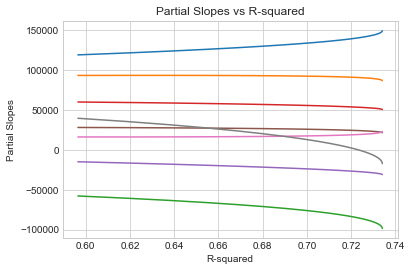

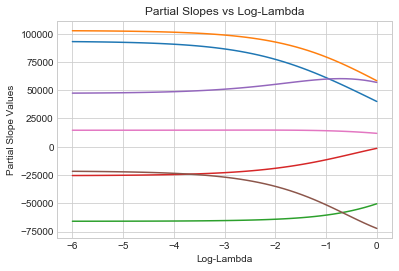

High Crime Tuned Lasso/Ridge: 
 MAE: 101583 
 MSE: 17315820228 
 R^2: 0.397


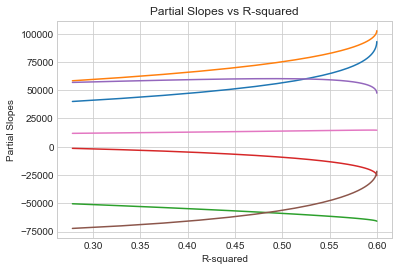

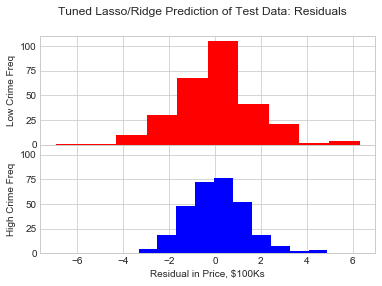

In [258]:
# Now fit to training data and test on unseen data to generate accuracy measures.
y_pred = fit_ridge_model(lowtform, ZL, ZL.Price).predict(XXL) 
mae = mean_absolute_error(y_pred, YYL)
mse = mean_squared_error(y_pred,YYL)
r2 = r2_score(y_pred,YYL)
resid_low = YYL - y_pred
print("Low Crime Tuned Lasso/Ridge: \n MAE: {:.0f} \n MSE: {:.0f} \n R^2: {:.3f}"
      .format(mae, mse, r2))

y_pred = fit_ridge_model(hightform, ZH, ZH.Price).predict(XXH) 
mae = mean_absolute_error(y_pred, YYH)
mse = mean_squared_error(y_pred,YYH)
r2 = r2_score(y_pred,YYH)
resid_high = YYH - y_pred
print("High Crime Tuned Lasso/Ridge: \n MAE: {:.0f} \n MSE: {:.0f} \n R^2: {:.3f}"
      .format(mae, mse, r2))

# Combined plot of residuals
plt.figure()
f, axarr = plt.subplots(2, sharex=True, sharey=True)
f.suptitle('Tuned Lasso/Ridge Prediction of Test Data: Residuals')
axarr[0].hist(resid_low/1e5, color='red')
axarr[1].hist(resid_high/1e5, color='blue')
f.subplots_adjust(hspace=0)
axarr[0].grid(True)
axarr[0].set_ylabel('Low Crime Freq')
axarr[1].grid(True)
axarr[1].set_ylabel('High Crime Freq')
for ax in axarr.flat:
    ax.set(xlabel='Residual in Price, $100Ks')

The residuals are nice and normal, and I log the MAE for choosing models later.

In [259]:
# Compute Regression Model On Principal Components
# Holy cow this model is a HORRIFIC Fit, DISCARD!
# No coeff with p<0.05 except the intercept, Fstat = 0.83, AdjRsq = -0.007...

# Calculate all the Principal components
cols = low_t.drop('Price',axis=1).columns.tolist()
X = low_t.drop('Price',axis=1).as_matrix(columns=cols)
y = low_t.Price
pca = PCA(n_components=len(cols))
pca_result = pca.fit_transform(X)
pccols = ['pc{}'.format(i+1) for i in range(len(cols))]
pca_df = pd.DataFrame(data = pca_result, columns=pccols)
# Here is our data projected onto the four principal components.
print(pca_df.head())
print(pca_df.shape)
#Add the target var for modeling
pca_df['Price'] = y
# Fit the PCR Model
pcform = 'Price ~ ' + ' + '.join(pccols)
pcr_model = sm.ols(formula = pcform, data=pca_df)

results = pcr_model.fit()
n_points = pca_df.shape[0]
y_output = pca_df['Price'].values.reshape(n_points, 1)

# Get most of the linear regression statistics we are interested in:
print("PCR Model")
print(results.summary())

#For the record, I also did a PCR on the full data, and it was also horrific
# I am SO not repeating this shit show for any other variables. 

        pc1       pc2       pc3       pc4       pc5       pc6       pc7  \
0  2.748311 -1.408796  0.502419 -0.015793 -0.268779  0.578757 -0.925653   
1 -2.028639  0.099472 -1.053500 -0.124421  0.885253  0.385527 -0.000195   
2  0.499617  0.285672 -1.366070  0.988209  0.739480 -0.977523  0.835282   
3 -0.253509 -2.116615  0.008381  0.631493 -1.121661 -0.416580 -0.545463   
4 -2.453337 -0.555093 -0.056084  0.023608  0.383411 -1.253655  1.087775   

        pc8       pc9  
0  0.237385  0.135367  
1  0.381428 -0.028471  
2 -0.016159 -0.014615  
3  0.172515 -0.101452  
4 -0.690514 -0.019539  
(1571, 9)
PCR Model
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.6209
Date:                Mon, 28 May 2018   Prob (F-statistic):          

I'm discarding the PCR models on the basis of the terrible R2 alone.



Naive Bayes...

Low Crime Baysian ridge: 
 MAE: 129482 
 MSE: 29813134735 
 R^2: 0.657
High Crime Baysian ridge: 
 MAE: 101738 
 MSE: 17166876940 
 R^2: 0.393


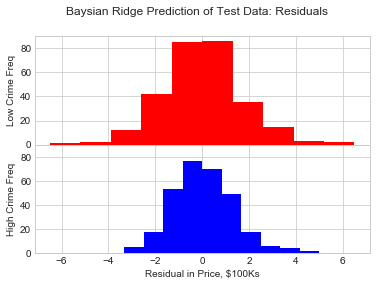

In [260]:
# Run Naive Bayes on test dataset, using a form suited to continuous data

# Fit a Bayesian Ridge Regression
print ('\n\nNaive Bayes...\n')
# Low crime first
n_features = XL.shape[1]
clf = BayesianRidge(compute_score=True)
y_pred = clf.fit(XL, YL).predict(XXL) 
mae = mean_absolute_error(y_pred, YYL)
mse = mean_squared_error(y_pred,YYL)
r2 = r2_score(y_pred,YYL)
resid_low = YYL - y_pred
print("Low Crime Baysian ridge: \n MAE: {:.0f} \n MSE: {:.0f} \n R^2: {:.3f}"
      .format(mae, mse, r2))

# High crime second
n_features = XH.shape[1]
clf = BayesianRidge(compute_score=True)
y_pred = clf.fit(XH, YH).predict(XXH) 
mae = mean_absolute_error(y_pred, YYH)
mse = mean_squared_error(y_pred,YYH)
r2 = r2_score(y_pred,YYH)
resid_high = YYH - y_pred
print("High Crime Baysian ridge: \n MAE: {:.0f} \n MSE: {:.0f} \n R^2: {:.3f}"
      .format(mae, mse, r2))

# Combined plot of residuals
f, axarr = plt.subplots(2, sharex=True, sharey=True)
f.suptitle('Baysian Ridge Prediction of Test Data: Residuals')
axarr[0].hist(resid_low/1e5, color='red')
axarr[1].hist(resid_high/1e5, color='blue')
f.subplots_adjust(hspace=0)
axarr[0].grid(True)
axarr[0].set_ylabel('Low Crime Freq')
axarr[1].grid(True)
axarr[1].set_ylabel('High Crime Freq')
for ax in axarr.flat:
    ax.set(xlabel='Residual in Price, $100Ks')

The residuals are nice and normal, and I log the MAE for choosing models later.


Computing Lasso regularization path using the LARS ...

Low Crime Lasso/LARS ridge: 
 MAE: 129430 
 MSE: 29698361994 
 R^2: 0.660
High Crime Lasso/LARS ridge: 
 MAE: 101788 
 MSE: 17153514613 
 R^2: 0.400


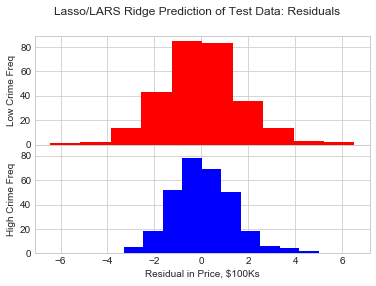

In [261]:
print("\nComputing Lasso regularization path using the LARS ...\n")

# Low crime first
reg = linear_model.LassoLars(alpha=0.05)
y_pred = reg.fit(XL,YL).predict(XXL)
mae = mean_absolute_error(y_pred, YYL)
mse = mean_squared_error(y_pred,YYL)
r2 = r2_score(y_pred,YYL)
resid_low = YYL - y_pred
print("Low Crime Lasso/LARS ridge: \n MAE: {:.0f} \n MSE: {:.0f} \n R^2: {:.3f}"
      .format(mae, mse, r2))


# High crime second
reg = linear_model.LassoLars(alpha=0.05)
y_pred = reg.fit(XH,YH).predict(XXH)
mae = mean_absolute_error(y_pred, YYH)
mse = mean_squared_error(y_pred,YYH)
r2 = r2_score(y_pred,YYH)
resid_high = YYH - y_pred
print("High Crime Lasso/LARS ridge: \n MAE: {:.0f} \n MSE: {:.0f} \n R^2: {:.3f}"
      .format(mae, mse, r2))

# Shared plot of residuals
f, axarr = plt.subplots(2, sharex=True, sharey=True)
f.suptitle('Lasso/LARS Ridge Prediction of Test Data: Residuals')
axarr[0].hist(resid_low/1e5, color='red')
axarr[1].hist(resid_high/1e5, color='blue')
f.subplots_adjust(hspace=0)
axarr[0].grid(True)
axarr[0].set_ylabel('Low Crime Freq')
axarr[1].grid(True)
axarr[1].set_ylabel('High Crime Freq')
for ax in axarr.flat:
    ax.set(xlabel='Residual in Price, $100Ks')

The four models I have trained have the following mean absolute error, which is a common metric for choosing a model for a set of data: 

| Model | Low Crime MAE (\$)   | High Crime MAE (\$)|
|------|------|------|
|   Fwd Selection  | 129,430| 101,786|
| Naive Baise/Ridge| 129,482| 101,738|
| Lasso/LARS | 129,430| 101,788|
| Tuned Lasso/Ridge| 132,005| 101,583|

The low-crime house prices are best predicted by Fwd Selection and Lasso/LARS, while the high-crime houses are best predicted by the Tuned Lasso/Ridge. Next I will compute 95%, 5% confidence intervals on the coefficients for those models. Finally I will use them to predict the validation data which has been held back this whole time to evaulate their final performance.

In [262]:
print("\n\nBootstrap 95% Confidence Intervals on Model Parameters\n")

def bootstrap_ols_parameters(inputform, data_df, modtype='ols', n_boots=100):
    from collections import defaultdict
    import statsmodels.formula.api as sm
    # Bootstrap 95% confidence intervals on parameters of "modtype" model
    # 'ols' and 'tuned-ridge' are two accepted options for modtype
    # Resample with replacement each row
    # Return: dataframe with index=bounds(percentiles), columns=params
    dd = defaultdict(list) # collect n_params dicts times n_boots lists
    for _ in range(n_boots):
        # Create a sampling of the rows, same size, with replacement
        sample_df = data_df.sample(n=n_points, replace=True)
        # Fit the model. Must get something back with params
        if modtype == 'ols':
            results = sm.ols(formula=inputform, data=sample_df).fit()
        elif modtype == 'tuned-ridge':
            results = fit_ridge_model(inputform, sample_df, sample_df.Price)
        # Store parameters in the collection of dictionaries
        for key,value in results.params.iteritems():
            dd[key].append(value)
    # Once bootstraps are done, convert results into a dataframe
    # This is a LOT faster than appending dataframes inside loop
    params_df = pd.DataFrame(dd)
    lower_bounds = params_df.quantile(0.05)
    upper_bounds = params_df.quantile(0.95)
    output = pd.DataFrame(data=[lower_bounds, upper_bounds, upper_bounds-lower_bounds])
    output.rename(index={'Unnamed 0':'Spread'},inplace=True)
    return output
            

print("\n\n Low Crime - Bootstrap 5%,95% CI on Forward Selected OLS Model Parameters:\n")
print(bootstrap_ols_parameters(lowtform, ZL, 'ols'))

print("\n\nHigh Crime - Bootstrap 5%,95% CI on Tuned Lasso Model Parameters:\n")
print(bootstrap_ols_parameters(hightform, high_t))




Bootstrap 95% Confidence Intervals on Model Parameters



 Low Crime - Bootstrap 5%,95% CI on Forward Selected OLS Model Parameters:

           Bathrooms      Bedrooms     Condition          Grade  \
0.05     7954.196127 -41219.017626  14149.764656  138185.638351   
0.95    37182.988316 -22905.992919  29268.714565  162035.776430   
Spread  29228.792189  18313.024707  15118.949909   23850.138079   

            Intercept    Sqft_Above    Sqft_Living      Sqft_Lot  \
0.05    553919.374278  35476.538721   67498.136809 -26267.781835   
0.95    572188.657812  65299.587442  104984.546943  -7242.716467   
Spread   18269.283534  29823.048722   37486.410133  19025.065368   

             Yr_Built  
0.05   -113218.625752  
0.95    -83949.720627  
Spread   29268.905125  


High Crime - Bootstrap 5%,95% CI on Tuned Lasso Model Parameters:

            Bedrooms     Condition          Grade      Intercept  \
0.05   -31980.258198   8435.560178   96161.270335  527515.741261   
0.95   -14748.901863 

Notice that the spread on the coefficients is lower on total crime (on par with condition and yr built) but ONLY for the high crime areas. In the low crime areas, total crime has a very wide spread relative to condition, sqft_lot which are the tightest spread. 

** Interpretting model coefficients for high crime area **

The intercept of 52-54K means you need at least this much to buy an empty lot anywhere in the city. For houses and lots, more space, especially living space, is a primary driver of increased housing cost, followed by the condition the home is in (does it need a lot of repairs, or is it move-in ready?) and its grade (is it on a nice hill, or in a valley, possibly with drainage issues?). More bedrooms and older homes tend to suppress the price, as does the lot size -- although based on prior analysis I don't totally buy the lot size relationship at least in high crime neighborhoods because there just weren't a lot of big lots to base that on. Given that, I suspect the lot size coefficient is a reflection of homes using the full lot to maximize livable square footage. Year built is hard to interpret because we know that variable is kind of clustered at the low and high end, but it would seem people don't like old houses, all else equal. The more bedrooms things makes sense: if you only have N sqfoot to work with, most folk would rather have a big master suite and fewer bedrooms. 

** Interpretting model coefficients for low crime areas**

It costs a little more, 55-57K, to buy in a low crime area absent any improvements (the intercept). The other coefficients, at least in terms of sign and interpretation, mimic the high crime model, despite being generated by a different process. The difference is that the negative coefficients are mostly larger and the positive coefficients are mostly smaller. The lot size coefficient is still negative but smaller magnitude, probably because lots are generally bigger in low crime neighborhoods and when the house reaches a certain size people would like to have a yard, but they'd still prefer the house more or less maximize the livable square footage. The number of bathrooms has a positive coefficient, wheras it was absent in the high-crime model. More bathrooms is definitely a good thing to have, provided you didn't sacrifice square footage or newness to get it. The yr-built coefficient dwarfs the bathroom coefficient: if old houses have fewer bathrooms, people definitely don't want the old house, the number of bathrooms being more of a side benefit. 

In [263]:
# Same thing for scikit models. I am not sure get_params actually varies, I might want to bootstrap coefficients
def bootstrap_sk_parameters(X, Y, modtype, n_boots=100):
    from collections import defaultdict
    import statsmodels.formula.api as sm
    # Bootstrap 95% confidence intervals on parameters scikit type models
    # Must have .fit(XL,YL).get_params() dictionary
    # Resample with replacement each row
    # Return: dataframe with index=bounds(percentiles), columns=params
    dd = defaultdict(list) # collect n_params dicts times n_boots lists
    for _ in range(n_boots):
        # Create a sampling of the rows, same size, with replacement
        # Sample rows then grab same rows from features and target
        rows = np.random.binomial(n=1, p=0.4, size=len(X)).astype(bool)
        x, y = X[rows], Y[rows]
        # Fit the model. Must get something back with dict of params
        # OLS-style params are called coef_ in scikit & they're ordered by features
        if modtype == 'baysian':
           model = BayesianRidge(compute_score=True).fit(x,y)
        elif modtype == 'lars':
            model = linear_model.LassoLars(alpha=0.05).fit(x,y)
        results = dict(zip(x,model.coef_))
        # Store parameters in the collection of dictionaries
        for key,value in results.items():
            dd[key].append(value)
    # Once bootstraps are done, convert results into a dataframe
    # This is a LOT faster than appending dataframes inside loop
    params_df = pd.DataFrame(dd)
    lower_bounds = params_df.quantile(0.05)
    upper_bounds = params_df.quantile(0.95)
    output = pd.DataFrame(data=[lower_bounds, upper_bounds, upper_bounds-lower_bounds])
    output.rename(index={'Unnamed 0':'Spread'},inplace=True)
    return output

print("\nLow Crime - Bootstrap 5%,95% CI on Lasso/LARS Parameters:\n")
print(bootstrap_sk_parameters(XL,YL,'lars'))


Low Crime - Bootstrap 5%,95% CI on Lasso/LARS Parameters:

           Bathrooms      Bedrooms     Condition          Grade    Sqft_Above  \
0.05     9649.734373 -43000.613531  11140.032227  125594.758956  30797.613819   
0.95    42347.541659 -12942.541394  32190.650895  160673.504402  73945.448685   
Spread  32697.807285  30058.072136  21050.618668   35078.745446  43147.834866   

          Sqft_Living      Sqft_Lot    Total_Crime       Yr_Built  
0.05     59988.121398 -27323.657951   90284.985507 -112394.178717  
0.95    111181.414630    631.319408  199728.148197  -74949.656309  
Spread   51193.293232  27954.977358  109443.162690   37444.522408  


I included this function since the sklearn models have a different interface than the OLS models. Lasso/LARS had an MAE on the low crime that was the same as the Fwd Selection which is why I am including this table. With the exception of Sqft_Lot, ALL the other coefficients have greater 95%-5% CI spread than the Fwd Selection low-crime model. 

Using this as a tie breaker -- The logic being that if we compute the model on many samples of a population, you'll get different forms of the equation(s) every time, and if the coefficients are quite sensitive to the subsampling, that's not a model you should rely on. Or, perhaps, not a predictor you should rely on -- we should choose the OLS Fwd Selection model for low crime density house prices.




 Low Crime: forward-selected OLS model
Low Crime Fwd Selected OLS: 
 MAE: 128581 
 MSE: 31986771310 
 R^2: 0.558


 High Crime: Tuned Lasso/Ridge Model
Max Rsq 0.60 achieved with lambda = 0.0025


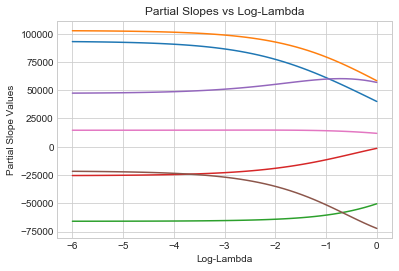

High Crime Tuned Lasso/Ridge: 
 MAE: 103165 
 MSE: 18128239408 
 R^2: 0.246


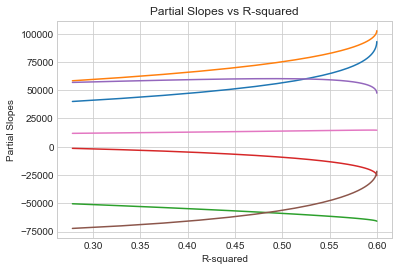

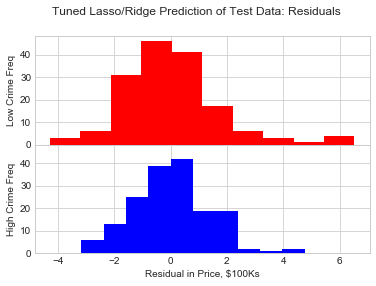

In [264]:
# Finally, validate the 2 chosen models on the untouched validation dataset

print('\n\n Low Crime: forward-selected OLS model')
mod,_,_ = forward_selected(ZL, 'Price', print_table=False)
y_pred = mod.predict(XXLval) 
mae = mean_absolute_error(y_pred, YYLval)
mse = mean_squared_error(y_pred,YYLval)
r2 = r2_score(y_pred,YYLval)
resid_low = YYLval - y_pred
print("Low Crime Fwd Selected OLS: \n MAE: {:.0f} \n MSE: {:.0f} \n R^2: {:.3f}"
      .format(mae, mse, r2))


print('\n\n High Crime: Tuned Lasso/Ridge Model')

y_pred = fit_ridge_model(hightform, ZH, ZH.Price).predict(XXHval) 
mae = mean_absolute_error(y_pred, YYHval)
mse = mean_squared_error(y_pred,YYHval)
r2 = r2_score(y_pred,YYHval)
resid_high = YYHval - y_pred
print("High Crime Tuned Lasso/Ridge: \n MAE: {:.0f} \n MSE: {:.0f} \n R^2: {:.3f}"
      .format(mae, mse, r2))

# Combined plot of residuals
plt.figure()
f, axarr = plt.subplots(2, sharex=True, sharey=True)
f.suptitle('Tuned Lasso/Ridge Prediction of Test Data: Residuals')
axarr[0].hist(resid_low/1e5, color='red')
axarr[1].hist(resid_high/1e5, color='blue')
f.subplots_adjust(hspace=0)
axarr[0].grid(True)
axarr[0].set_ylabel('Low Crime Freq')
axarr[1].grid(True)
axarr[1].set_ylabel('High Crime Freq')
for ax in axarr.flat:
    ax.set(xlabel='Residual in Price, $100Ks')

The results when the selected, tuned models are applied to unseen validation data are pretty similar to what we saw when the trained models were first applied to test data. The R^2 are twice as high for the low-crime areas. The MAE for low-crime is \$128.5K and for high-crime is \$103.2K. The residual plots are normal and centered at zero, for the most part: the low crime residuals have a few 600000 errors in them. 

Overall these linear models are not great; I wish the MAE was not 1/5 of the mean price. Based on the visual exploration of the data, however, I do not think feature selection or higher-order polynomials would make a better model, it would probably just produce a more overfitted model. I think cluster-based analysis would help, and that is what I would do if I had more time to work on this. 